In [7]:
from torch_geometric.datasets import TUDataset
import matplotlib.pyplot as plt 
import networkx as nx
from torch_geometric.utils import to_networkx
import torch

In [2]:
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()

In [17]:
dataset = TUDataset(root='data/TUDataset', name='Mutagenicity')

Extracting data\TUDataset\Mutagenicity\Mutagenicity.zip
Processing...
Done!


In [21]:
data = dataset[0]

In [27]:
for i in dir(data) :
    print(i)

__call__
__cat_dim__
__class__
__contains__
__copy__
__deepcopy__
__delattr__
__delitem__
__dict__
__dir__
__doc__
__eq__
__format__
__ge__
__getattr__
__getattribute__
__getitem__
__getstate__
__gt__
__hash__
__inc__
__init__
__init_subclass__
__iter__
__le__
__len__
__lt__
__module__
__ne__
__new__
__reduce__
__reduce_ex__
__repr__
__setattr__
__setitem__
__setstate__
__sizeof__
__str__
__subclasshook__
__weakref__
_edge_attr_cls
_edge_to_layout
_edges_to_layout
_get_edge_index
_get_tensor
_get_tensor_size
_multi_get_tensor
_put_edge_index
_put_tensor
_remove_edge_index
_remove_tensor
_store
_tensor_attr_cls
_to_type
apply
apply_
batch
clone
coalesce
contains_isolated_nodes
contains_self_loops
contiguous
coo
cpu
csc
csr
cuda
debug
detach
detach_
edge_attr
edge_attrs
edge_index
edge_stores
edge_subgraph
edge_weight
from_dict
generate_ids
get_all_edge_attrs
get_all_tensor_attrs
get_edge_index
get_tensor
get_tensor_size
has_isolated_nodes
has_self_loops
is_coalesced
is_cuda
is_directed


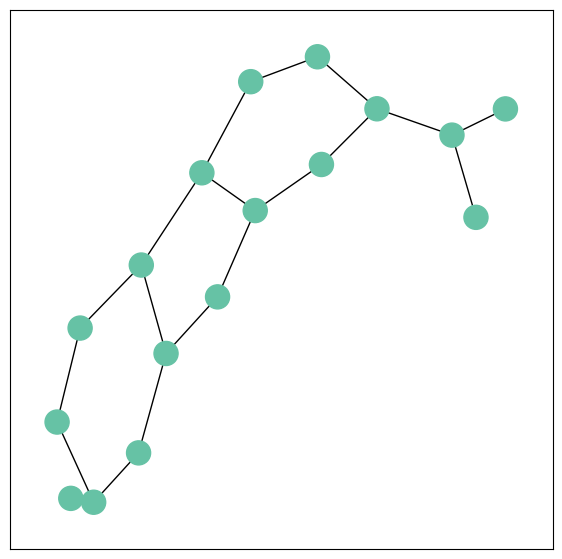

In [9]:
import random 
r = random.randint(1, len(dataset))
data = dataset[r]

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=torch.ones(data.x.size(0)))

In [28]:
print(data.batch)

None
